In [31]:
import os
import skimage as ski
import watershed_udder as wu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyrealsense2 as rs
from skimage.restoration import inpaint
import shapely
from skimage.measure import find_contours

In [40]:
import pandas as pd

In [41]:
df = pd.read_csv(r"validate_watershed\survey_groups.csv")

In [44]:
[file + ".tif" for file in df.filename]

['1057_20231117_140050_frame_621.tif',
 '1057_20231117_140050_frame_286.tif',
 '1057_20231117_140050_frame_611.tif',
 '1057_20231117_140050_frame_610.tif',
 '1057_20231117_140050_frame_629.tif',
 '1057_20231117_140050_frame_633.tif',
 '970_20231117_150812_frame_629.tif',
 '970_20231117_150812_frame_622.tif',
 '970_20231117_150812_frame_222.tif',
 '970_20231117_150812_frame_551.tif',
 '970_20231117_150812_frame_632.tif',
 '970_20231117_150812_frame_613.tif',
 '764_20231117_144922_frame_812.tif',
 '764_20231117_144922_frame_696.tif',
 '764_20231117_144922_frame_769.tif',
 '764_20231117_144922_frame_843.tif',
 '764_20231117_144922_frame_809.tif',
 '764_20231117_144922_frame_689.tif',
 '1223_20231117_110830_frame_760.tif',
 '1223_20231117_110830_frame_551.tif',
 '1223_20231117_110830_frame_639.tif',
 '1223_20231117_110830_frame_785.tif',
 '1223_20231117_110830_frame_745.tif',
 '1223_20231117_110830_frame_536.tif',
 '1116_20231117_141845_frame_248.tif',
 '1116_20231117_141845_frame_245.tif'

In [38]:
def get_angle(right_kp, left_kp):
    angle = np.arctan2(right_kp[1]-left_kp[1], right_kp[0]-left_kp[0])
    return angle

def get_center(right_kp, left_kp):
    return shapely.centroid(MultiPoint([right_kp, left_kp])).coords[0] 

def get_orientation(right_kp, left_kp):
    if right_kp[0] < left_kp[0]:
        orientation = -1 # up 
    else: 
        orientation = 1 # down
    return orientation

def rotate_udder(udder, right_kp, left_kp):
    k = get_orientation(right_kp, left_kp)
    center = get_center(right_kp, left_kp)
    angle = get_angle(right_kp, left_kp)
    rotated_udder = rotate(udder, np.rad2deg(k*angle), center = center, preserve_range = True)
    return rotated_udder

def rotate_points(right_kp, left_kp):
    k = get_orientation(right_kp, left_kp)
    points = np.concatenate([[right_kp], [left_kp]])
    points2 = points.copy()
    angle = get_angle(right_kp, left_kp)
    center = get_center(right_kp, left_kp)
    rot_mat = np.array([[np.cos(-k*angle), -np.sin(-k*angle)], [np.sin(-k*angle), np.cos(-k*angle)]])
    #
    points2[:, 0] = points[:, 0] - center[0]
    points2[:, 1] = points[:, 1] - center[1]
    # 
    points2 = np.transpose(np.dot(rot_mat, np.transpose(points2[:, :2])))
    points2[:, 0] = points2[:, 0] + center[0]
    points2[:, 1] = points2[:, 1] + center[1]
    rotated_points = points2.copy()
    return rotated_points

def udder_line_inp(img,udder_shp, rf_kp, lf_kp, ax):
    miss_mask = img.copy()
    miss_mask[: :] = 0
    miss_mask[udder == 0] = 1
    inp_udder = inpaint.inpaint_biharmonic(img, miss_mask)
    udder2 = rotate_udder(inp_udder, rf_kp, lf_kp)
    points2 = rotate_points(rf_kp, lf_kp)
    yloc = np.floor(points2[0,1]).astype(int)
    # fig, ax = plt.subplots()
    for i in range(-10,10):
        yloc2 = yloc + i 
        line = LineString([(0, yloc2), (im_width, yloc2)])
        intersection = udder_shp.exterior.intersection(line).geoms
        endpoints = np.array([list(intersection[0].coords[0]), list(intersection[1].coords[0])])
        start = np.floor(endpoints[np.argmin(endpoints[:, 0])]).astype(int)
        end = np.floor(endpoints[np.argmax(endpoints[:, 0])]).astype(int)
        line_vals = udder2[yloc2][list(range(start[0], end[0]))]
        ax.plot(line_vals)

In [19]:
def update_kp(kp_ws, ws_label, img):
    newkp_dict = {}
    # fig, axs = plt.subplots(ncols = 4, nrows= 1, figsize = (12, 4))
    for key in kp_ws.keys():
        label = kp_ws[key]
        mask = ws_label.copy()
        mask[mask!= label] = 0
        mask[mask == label] = 1
        quarter = (mask*img).astype(float)
        quarter[quarter==0] =np.nan
        mins = np.argwhere(quarter== np.nanmin(quarter))
        x = np.round(np.median(mins[:, 1]), 0).astype(int)
        y = np.round(np.median(mins[:, 0]), 0).astype(int)
        newkp_dict[key] = (x,y)
    
    return newkp_dict

In [20]:
# list files 
dirpath = os.getcwd()
ws_dir = r"validate_watershed\watershed_segments"
corr_dir = r"validate_watershed\watershed_correspondence"
label_dir = os.path.join(dirpath, r"validate_watershed\pred_labels")
kp_dir = os.path.join(label_dir, r"keypoints")
sg_dir = os.path.join(label_dir, r"segments")
img_dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_video\depth_images")
filenames = [file.replace(".npy", "") for file in os.listdir(ws_dir)]

In [21]:
video_path =  os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_video\video_files\video_example.bag")

config = rs.config()
rs.config.enable_device_from_file(config, video_path, repeat_playback = False)
pipeline = rs.pipeline()
cfg = pipeline.start(config) # Start pipeline and get the configuration it found
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intr = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics

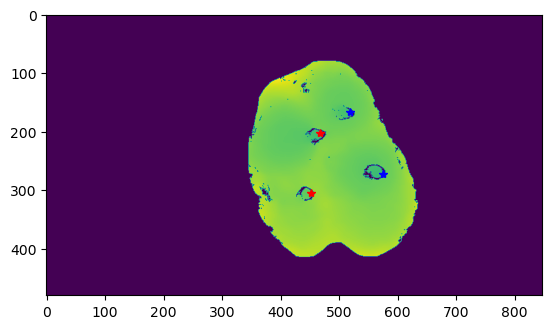

In [39]:
for file in filenames[:1]:
    # udder object
    udder = wu.udder_object(file + ".tif", img_dir, label_dir, array = 0)
    # read image
    img = udder.img
    # read labels
    segment = udder.get_segment()
    points = udder.get_keypoints()
    
    # reas WS segmentation
    ws_label = np.load(os.path.join(ws_dir, file + ".npy"))
    kp_ws = pd.read_csv(os.path.join(corr_dir, file +".csv")).loc[0].to_dict()

    new_kp = update_kp(kp_ws, ws_label, img)
    plt.imshow(img*udder.get_mask())
    plt.plot(new_kp["lf"][0], new_kp["lf"][1], "*r")
    plt.plot(new_kp["rf"][0], new_kp["rf"][1], "*b")
    plt.plot(new_kp["lb"][0], new_kp["lb"][1], "*r")
    plt.plot(new_kp["rb"][0], new_kp["rb"][1], "*b")
    plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8))= plt.subplots(4, 2,  figsize=(15, 20))
udder_line_conv(img, udder_shp, rf_kp, lf_kp, ax1)
ax1.title.set_text('conv_front')
udder_line_inp(img,udder_shp, rf_kp, lf_kp, ax2)
ax2.title.set_text('inp_front') 
udder_line_conv(img,udder_shp, rb_kp, lb_kp, ax3)
ax3.title.set_text('conv_back')
udder_line_inp(img, udder_shp, rb_kp, lb_kp, ax4)
ax4.title.set_text('inp_back')
udder_line_conv(img,udder_shp, rf_kp, rb_kp, ax5)
ax5.title.set_text('conv_right')
udder_line_inp(img,udder_shp, rf_kp, rb_kp, ax6)
ax6.title.set_text('inp_right')
udder_line_conv(img, udder_shp, lf_kp, lb_kp, ax7)
ax7.title.set_text('conv_left')
udder_line_inp(img, udder_shp, lf_kp, lb_kp, ax8)
ax8.title.set_text('conv_left')